In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import numpy as np
import random
from collections import Counter
import os
import matplotlib.pyplot as plt
import importlib

# custom import
import dataset
import NNv2 as NN

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: " + str(device))

device: cuda


In [3]:
# parameters
vocab_size = 1024
embedding_dim = 16
n = 9
input_size = embedding_dim
hidden_size = 64

learning_rate = 1e-3
batch_size = 512

In [4]:
# model
importlib.reload(NN)

model = NN.LSTM(vocab_size, input_size, embedding_dim, hidden_size).to(device)
print(model)

LSTM(
  (embedding): Embedding(1024, 16)
  (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=False)
  (lstm): LSTM(16, 64, batch_first=True)
  (linear_relu): Sequential(
    (0): Linear(in_features=64, out_features=16, bias=True)
    (1): ReLU()
  )
)


In [5]:
# prepare data
importlib.reload(dataset)

data = dataset.Dataset()
if os.path.exists("data_rnn.pkl"):
    data.load("data_rnn.pkl")
else:
    data.gen(vocab_size=vocab_size, n=n, batch_size=batch_size, filename='ChineseCorpus199801.txt', encoding="gbk", type="rnn")
    data.save("data_rnn.pkl")

In [6]:
# load model
if not os.path.exists("checkpoint"):
    os.mkdir("checkpoint")

pth_list = os.listdir("checkpoint")
latest_pth = None
cumulative_epoch = None
for pth in pth_list:
    if pth.endswith(".pth") and pth.startswith("LSTM"):
        if latest_pth is None:
            latest_pth = pth
        else:
            id = int(pth.split("-")[-1].split(".")[0])
            latest_id = int(latest_pth.split("-")[-1].split(".")[0])
            if id > latest_id:
                latest_pth = pth
                cumulative_epoch = id

if latest_pth is not None:
    print("load model from checkpoint/" + latest_pth)
    model.load_state_dict(torch.load("checkpoint/" + latest_pth))
    model.eval()

In [7]:
# prepare trainer
if cumulative_epoch is None:
    cumulative_epoch = 0
x_record = []
y_record = []

trainer = NN.Trainer(learning_rate, model)

In [8]:
# train
epochs = 60
learning_rate = 1e-3
for t in range(epochs):
    print(f"Epoch {cumulative_epoch+1}\n-------------------------------")
    trainer.train(data.train_dataloader, learning_rate=learning_rate)
    correct, test_loss = trainer.test(data.test_dataloader)

    cumulative_epoch+=1
    x_record.append(cumulative_epoch)
    y_record.append((correct, test_loss, learning_rate))
    
    if cumulative_epoch % 5 == 0:
        if not os.path.exists('checkpoint'):
            os.makedirs('checkpoint')
        torch.save(trainer.model.state_dict(), './checkpoint/LSTM-'+str(cumulative_epoch)+'.pth')
print("Done!")

Epoch 1
-------------------------------
loss: 6.428787  [51200/796108]
loss: 5.696556  [102400/796108]
loss: 4.591511  [153600/796108]
loss: 4.408649  [204800/796108]
loss: 4.285647  [256000/796108]
loss: 4.243456  [307200/796108]
loss: 4.147332  [358400/796108]
loss: 4.158883  [409600/796108]
loss: 4.063223  [460800/796108]
loss: 4.118515  [512000/796108]
loss: 4.129437  [563200/796108]
loss: 3.985906  [614400/796108]
loss: 4.083585  [665600/796108]
loss: 3.855361  [716800/796108]
loss: 4.031395  [768000/796108]
Test: 
 Accuracy: 37.3%, Avg loss: 3.982287 

Epoch 2
-------------------------------
loss: 3.977180  [51200/796108]
loss: 4.036124  [102400/796108]
loss: 4.052179  [153600/796108]
loss: 4.001120  [204800/796108]
loss: 3.883312  [256000/796108]
loss: 3.974638  [307200/796108]
loss: 3.993079  [358400/796108]
loss: 3.911714  [409600/796108]
loss: 3.906459  [460800/796108]
loss: 3.896485  [512000/796108]
loss: 3.920686  [563200/796108]
loss: 3.830613  [614400/796108]
loss: 3.8552

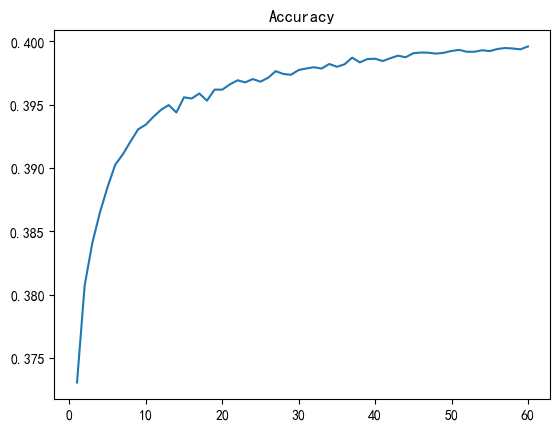

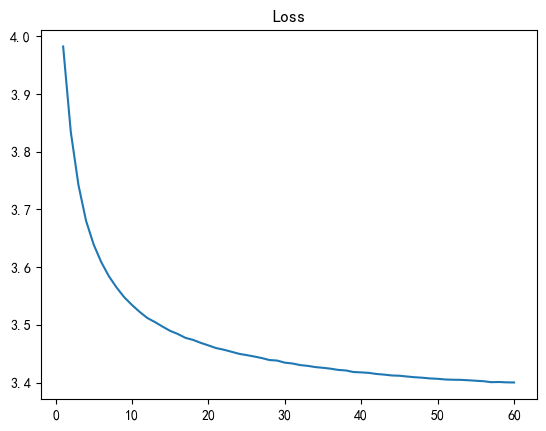

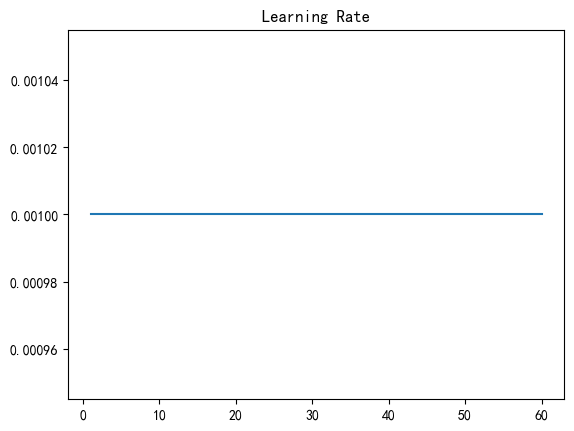

In [9]:
# plot the accuracy and loss curves
plt.plot(x_record, np.array(y_record)[:,0])
plt.title("Accuracy")
plt.show()
plt.plot(x_record, np.array(y_record)[:,1])
plt.title("Loss")
plt.show()
plt.plot(x_record, np.array(y_record)[:,2])
plt.title("Learning Rate")
plt.show()

In [12]:
def get_lookup_table(model):
    lookup_table = model.embedding.weight.data
    lookup_table = lookup_table.cpu().numpy()
    return lookup_table

lookup_table = get_lookup_table(trainer.model)
print(lookup_table.shape)

def top_10_similar(lookup_table, word_idx):
    word_vec = lookup_table[word_idx]
    similarity = np.dot(lookup_table, word_vec)/np.linalg.norm(lookup_table, axis=1)/np.linalg.norm(word_vec)
    a = np.argsort(-similarity)
    for i in a[:10]:
        name_list = [key for key,value in data.top_words.items() if value==i]
        if len(name_list) > 0:
            print(name_list[0], similarity[i])
        else:
            print("<UNK>", similarity[i])

word = random.choice(list(data.top_words.keys()))
word = "５/m"
print(word)
top_10_similar(get_lookup_table(trainer.model), data.top_words[word])


(1024, 16)
５/m
５/m 1.0000001
４/m 0.9949931
３/m 0.98976105
８/m 0.986077
１０/m 0.9640682
６/m 0.95115286
２０/m 0.9255739
７/m 0.9108216
２/m 0.8982253
３０/m 0.8968242
